In [265]:
import string
import csv
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

# Cleans csv files of actual twitter data: remove punctuation and stopwords (as defined by nltk)
def clean(name):
    
    file_in = name + '_picsremoved.csv'
    str = ''

    numrows = 0
    reader = csv.reader(open('Data/'+file_in))
    for row in reader:
        str = str + " " +(row[6])
        numrows = numrows + 1
    
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(str) 
  
    filtered = [w for w in word_tokens if not w in stop_words and w.isalpha()] 
    
    contain_https = ""
    
    # add https items to contain_https
    for i in range(len(filtered)):
        if 'https' in filtered[i] and len(filtered[i]) > 5:
            contain_https = contain_https + " " + filtered[i]
            
    # remove https items from filtered
    filtered = [w for w in filtered if not w in contain_https] 
    
    # split items in contain_https, tokenize
    contain_https_split = re.sub('https', ' https', contain_https)
    contain_https_split = word_tokenize(contain_https_split) 
    
    # add split https items back to filtered list
    for w in contain_https_split:
        filtered.append(w)
        
    # convert to lowercase    
    filtered = [w.lower() for w in filtered] 
            
    # return filtered list as string
    ret = (" ").join(filtered)
    return numrows, ret

In [266]:
from collections import defaultdict

# returns defaultdict of words and frequency
def word_count(words):
    counts = defaultdict(int)

    for word in words:
        counts[word] += 1

    return counts

In [267]:
from wordcloud import WordCloud
import matplotlib.pylab as plt
import matplotlib.pyplot as plot
import numpy as np

# visualizations of word frequency: print top ten most frequent words, histogram of word counts, word cloud
# returns average words per tweet
def word_frequency(name, filetype):
    if filetype == "txt":
        numtweets, person = clean_txt(name.lower())
    else:
        numtweets, person = clean(name.lower())
    
    words = person.split()
    avg_words_per_tweet = len(words) / numtweets
        
    d = word_count(words)
    
    # print top ten words
    print(sorted(d.items(), key=lambda v: v[1], reverse=True)[:10])
    
    logbins = np.geomspace(min(d.values()), max(d.values()), 15)
    
    # histogram of word counts
    plot.hist(d.values(), bins=logbins)
    
    plot.ylabel('Number of Words')
    plot.xscale('log')
    plot.xlabel('Word Count');
    plot.title(name + " Word Frequency")
    plot.show() 

    # word cloud
    cloud = WordCloud(width = 600, height = 400, 
                      background_color ='white', 
                      min_font_size = 10, collocations=False).generate(person)
    plt.imshow(cloud) 
    plt.axis("off") 
    plt.title(name)
    plt.show() 
    
    return avg_words_per_tweet

[('great', 1489), ('people', 1068), ('president', 903), ('democrats', 849), ('we', 815), ('country', 786), ('fake', 707), ('big', 707), ('many', 660), ('they', 632)]


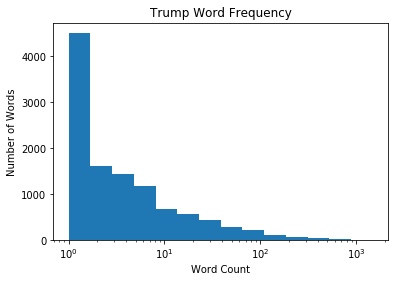

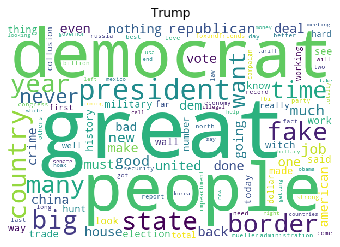

[('people', 1954), ('must', 1292), ('country', 1086), ('health', 1056), ('it', 945), ('need', 939), ('going', 851), ('campaign', 757), ('today', 683), ('make', 671)]


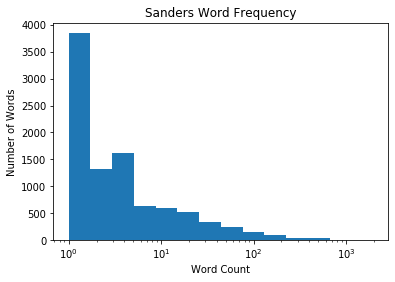

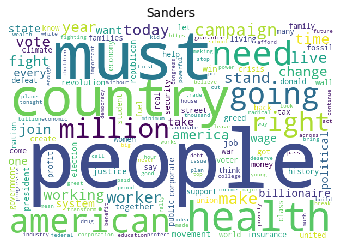

[('world', 307), ('great', 289), ('people', 252), ('one', 251), ('new', 216), ('this', 208), ('here', 192), ('help', 172), ('progress', 161), ('work', 156)]


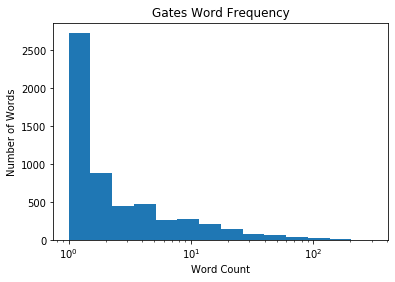

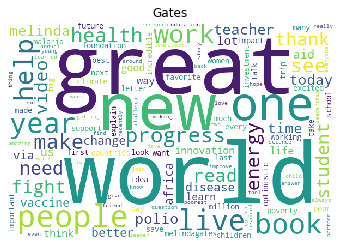

[('fight', 1575), ('people', 1106), ('need', 1043), ('make', 880), ('big', 832), ('plan', 708), ('it', 675), ('fighting', 656), ('today', 624), ('country', 598)]


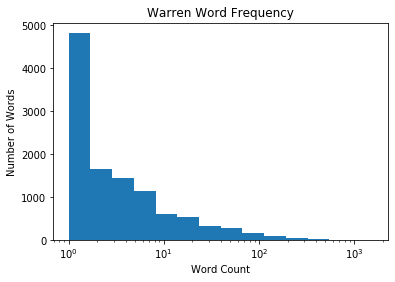

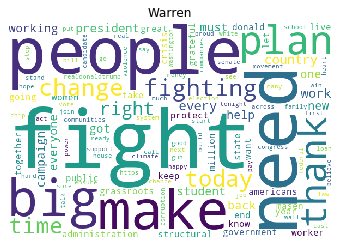

[('thank', 920), ('this', 644), ('like', 446), ('time', 433), ('if', 363), ('need', 323), ('working', 289), ('make', 288), ('https', 286), ('that', 280)]


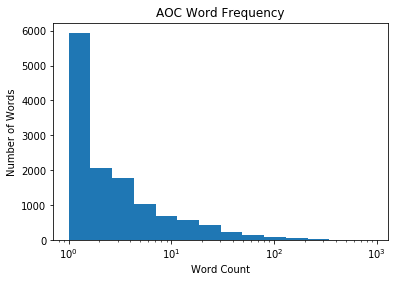

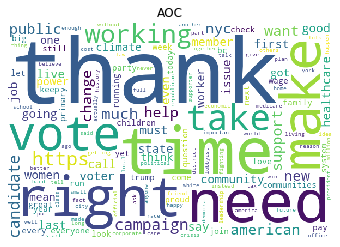

[('thanks', 439), ('see', 414), ('good', 400), ('get', 378), ('https', 366), ('believetour', 350), ('new', 349), ('believe', 262), ('today', 243), ('happy', 228)]


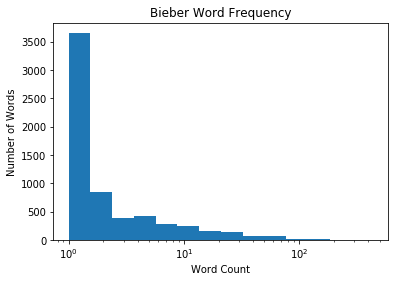

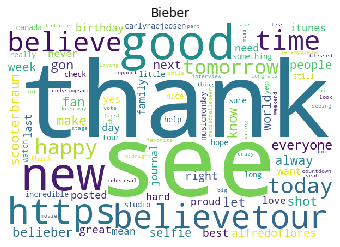

[('thank', 59), ('love', 53), ('the', 42), ('you', 41), ('like', 35), ('reputation', 34), ('see', 32), ('it', 30), ('new', 30), ('lover', 26)]


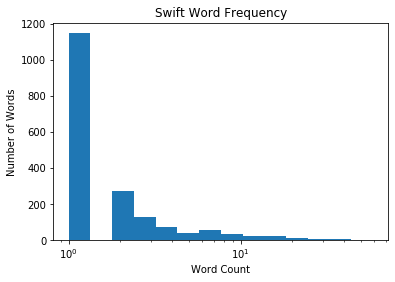

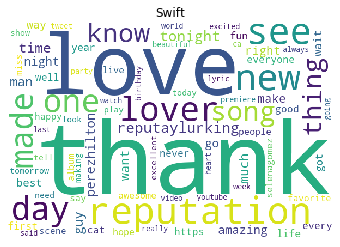

[('https', 1190), ('excited', 180), ('really', 146), ('get', 132), ('want', 132), ('jus', 126), ('got', 121), ('best', 117), ('make', 109), ('show', 104)]


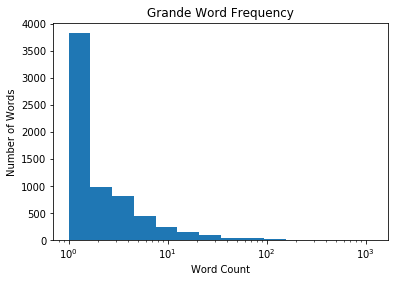

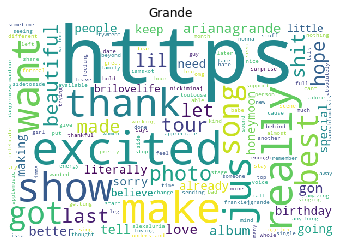

[('like', 501), ('https', 475), ('it', 222), ('people', 220), ('thank', 208), ('think', 187), ('really', 183), ('would', 162), ('never', 157), ('john', 145)]


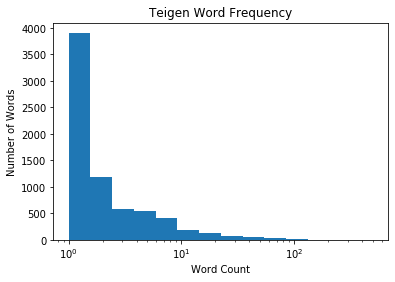

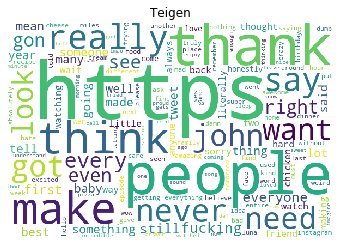

[('https', 1603), ('damn', 858), ('dopepic', 543), ('irresponsibletour', 510), ('it', 438), ('thank', 391), ('new', 287), ('make', 283), ('right', 262), ('morning', 248)]


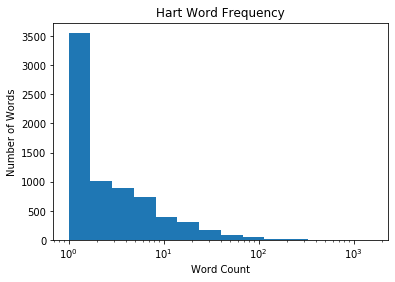

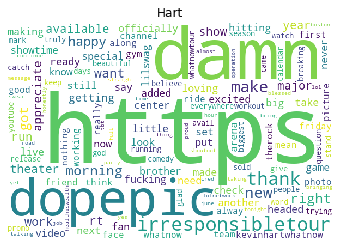

[('rt', 564), ('kingjames', 516), ('https', 348), ('good', 302), ('homie', 272), ('yes', 268), ('man', 259), ('tonight', 242), ('time', 241), ('thanks', 239)]


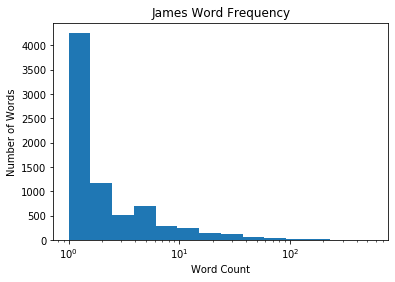

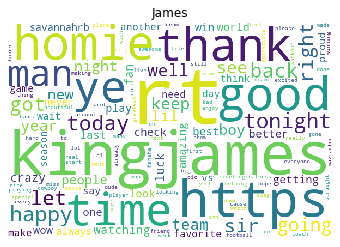

In [268]:
# Visualize word frequency for actual tweets
people = ['Trump','Sanders', 'Gates','Warren', 'AOC','Bieber', 'Swift', 'Grande', 'Teigen', 'Hart', 'James']
totals = []
for person in people:
    totals.append(word_frequency(person,'csv'))

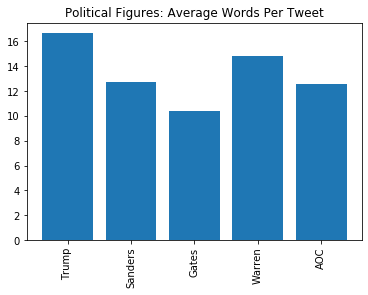

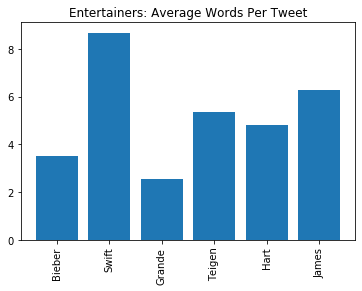

In [285]:
# Bar graph of average words per tweet for political figures
plot.bar(people[0:5], totals[0:5])
plot.title('Political Figures: Average Words Per Tweet')
plot.xticks(rotation=90)
plot.show()

# Bar graph of average words per tweet for entertainers
plot.bar(people[5:11], totals[5:11])
plot.title('Entertainers: Average Words Per Tweet')
plot.xticks(rotation=90)
plot.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sarahtam/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Trump


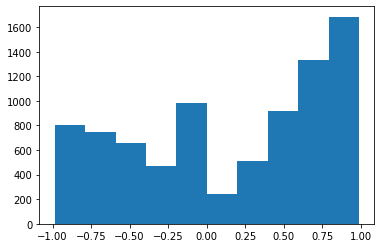

Sanders


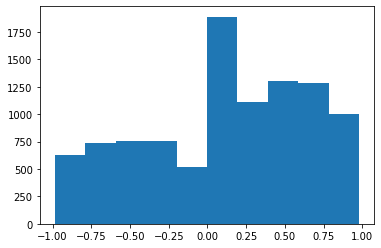

Gates


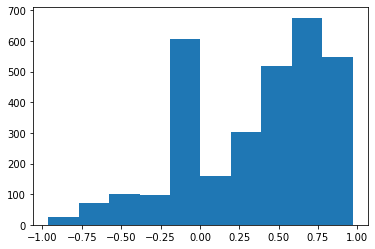

Warren


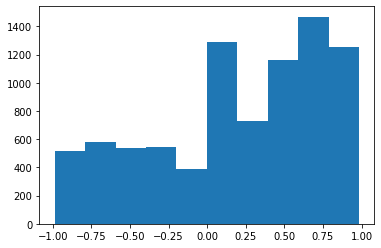

AOC


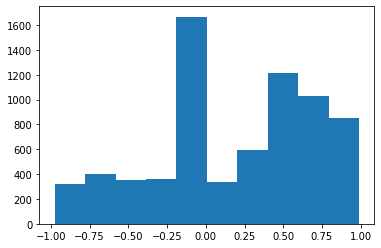

Bieber


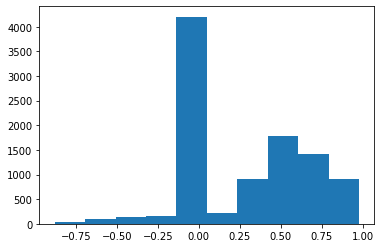

Swift


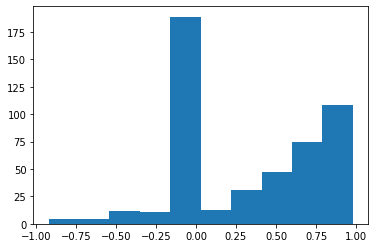

Grande


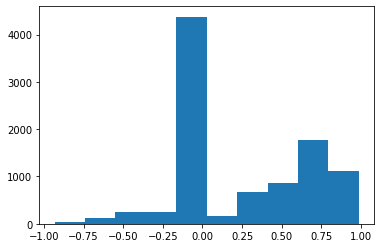

Teigen


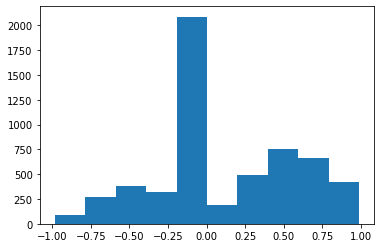

Hart


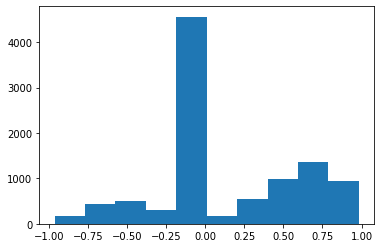

James


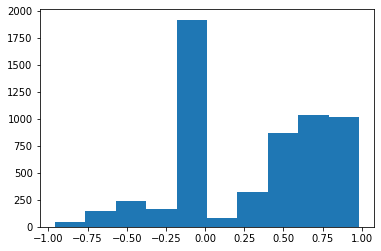

In [271]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import os

# Sentiment analysis
def sentiment(name, sid_obj):
    
    file_in = name + '_picsremoved.csv'
    
    pos=[]
    neu=[]
    neg=[]
    cmp=[]

    reader = csv.reader(open('Data/'+file_in))
    for row in reader:
        text = row[6]
        sentiment = sid_obj.polarity_scores(text) 
        pos.append(sentiment['pos'])
        neu.append(sentiment['neu'])
        neg.append(sentiment['neg'])
        cmp.append(sentiment['compound'])
        
#     plot.hist(pos)
#     plot.hist(neu)
#     plot.hist(neg)
    plot.hist(cmp)
    plot.show()
    
sid_obj = SentimentIntensityAnalyzer() 

for person in people:
    print(person)
    sentiment(person, sid_obj)


In [280]:
# Cleans txt files of network-generated tweets: remove punctuation and stopwords (as defined by nltk)
def clean_txt(name):
    str = ''
    file_name = 'Generated tweets GPT-2/' + name
    f = open(file_name, "r") 
    numrows = 0
    
    for line in f:
        if line[0] != '=':
            str = str + " " + line
            numrows = numrows + 1

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(str) 
    filtered = [w for w in word_tokens if not w in stop_words and w.isalpha()] 
    filtered = [w.lower() for w in filtered] 
#     filtered = [w.lower() for w in filtered if 'http' not in w] 
#     Consider removing all 'http' terms, since they consistently dominate
    
    ret = (" ").join(filtered)
    return numrows, ret

[('i', 444), ('http', 376), ('believe', 320), ('fragrance', 290), ('love', 265), ('u', 263), ('https', 212), ('the', 187), ('believetour', 178), ('thanks', 161)]


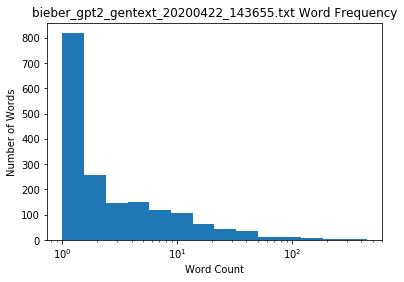

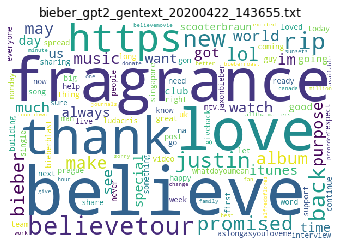

[('http', 1122), ('i', 603), ('https', 516), ('world', 426), ('the', 397), ('people', 240), ('one', 238), ('new', 209), ('help', 164), ('better', 158)]


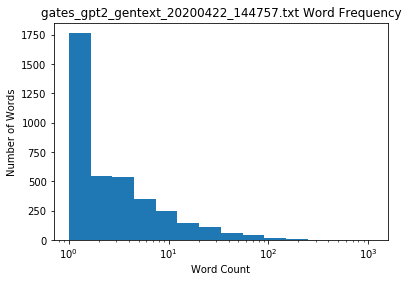

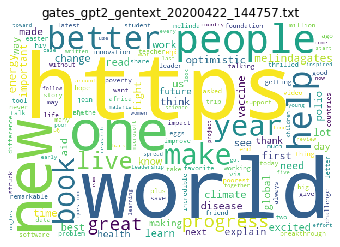

[('https', 1114), ('i', 708), ('movie', 222), ('tour', 221), ('http', 204), ('dopepic', 199), ('love', 198), ('people', 176), ('harts', 175), ('mac', 154)]


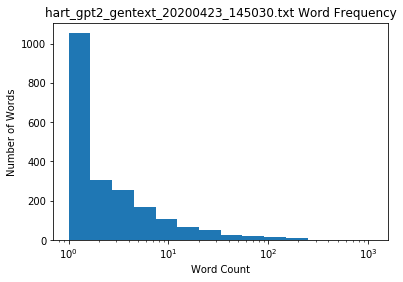

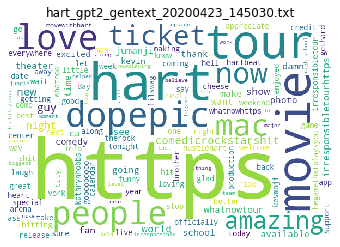

[('we', 670), ('i', 561), ('https', 451), ('people', 448), ('must', 414), ('the', 312), ('country', 264), ('us', 251), ('health', 247), ('trump', 235)]


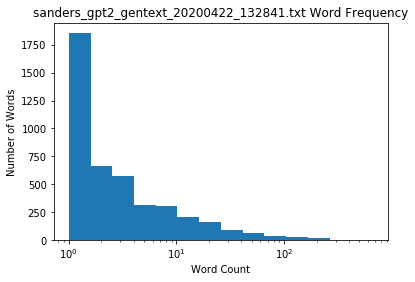

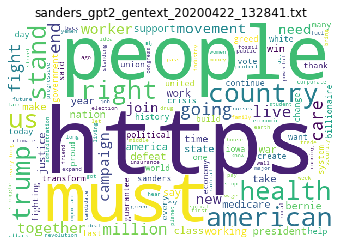

[('https', 643), ('great', 502), ('the', 468), ('i', 460), ('we', 444), ('people', 271), ('country', 254), ('thank', 244), ('president', 243), ('democrats', 227)]


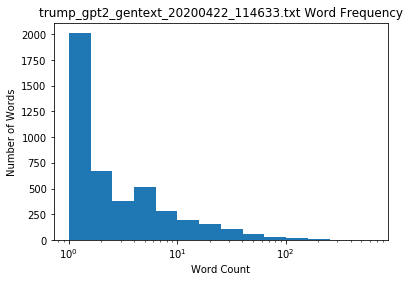

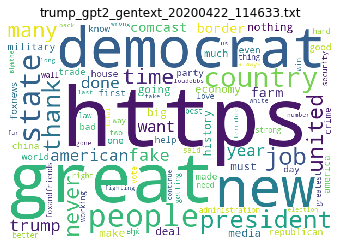

In [281]:
# Visualize word frequency for generated tweets

generated = ['bieber_gpt2_gentext_20200422_143655.txt',
          'gates_gpt2_gentext_20200422_144757.txt', 
          'hart_gpt2_gentext_20200423_145030.txt',
          'sanders_gpt2_gentext_20200422_132841.txt', 
          'trump_gpt2_gentext_20200422_114633.txt']
avg = []
for g in generated:
    avg.append(word_frequency(g,'txt'))

bieber_gpt2_gentext_20200422_143655.txt


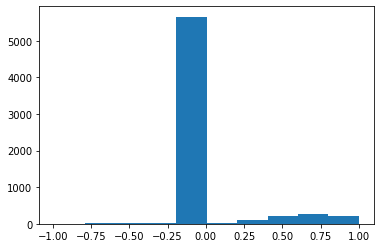

gates_gpt2_gentext_20200422_144757.txt


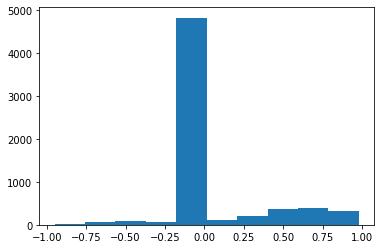

hart_gpt2_gentext_20200423_145030.txt


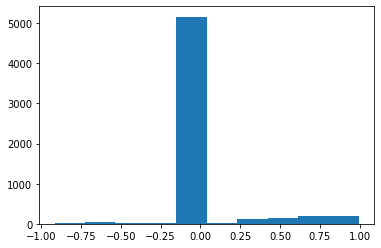

sanders_gpt2_gentext_20200422_132841.txt


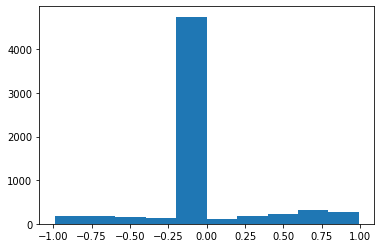

trump_gpt2_gentext_20200422_114633.txt


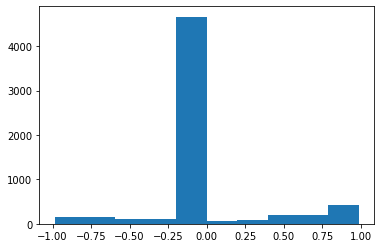

In [283]:
def sentiment_txt(name, sid_obj):
#     remove punctuation and stopwords (as defined by nltk)
    
    pos=[]
    neu=[]
    neg=[]
    cmp=[]

    file_name = 'Generated tweets GPT-2/' + name
    f = open(file_name, "r") 
    
    for text in f:
        sentiment = sid_obj.polarity_scores(text) 
        pos.append(sentiment['pos'])
        neu.append(sentiment['neu'])
        neg.append(sentiment['neg'])
        cmp.append(sentiment['compound'])
        
#     plot.hist(pos)
#     plot.hist(neu)
#     plot.hist(neg)
    plot.hist(cmp)
    plot.show()
    
sid_obj = SentimentIntensityAnalyzer() 

for g in generated:
    print(g)
    sentiment_txt(g, sid_obj)